In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ipywidgets import widgets
from IPython.display import display, HTML

# Stock-Sales Strategy in a Simplified Market


* https://docs.ocean.dwavesys.com/en/stable/examples/hybrid_cqm_stock_selling.html#example-cqm-stock-selling


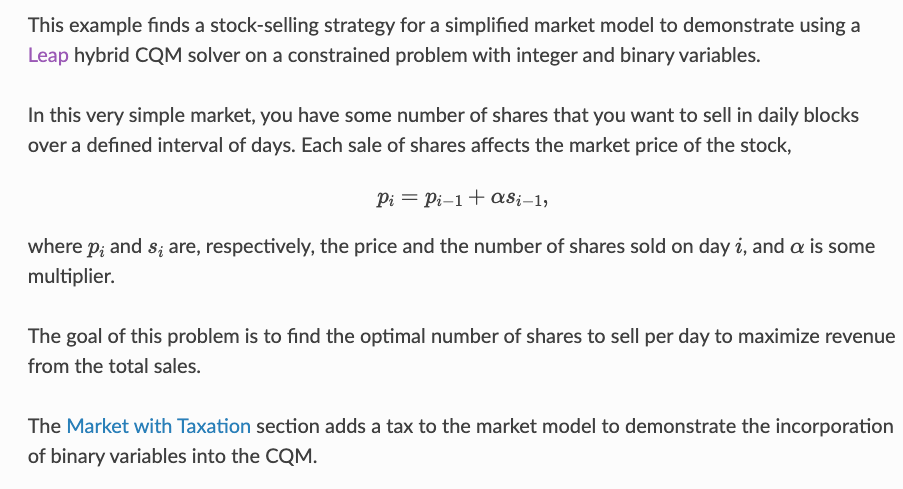
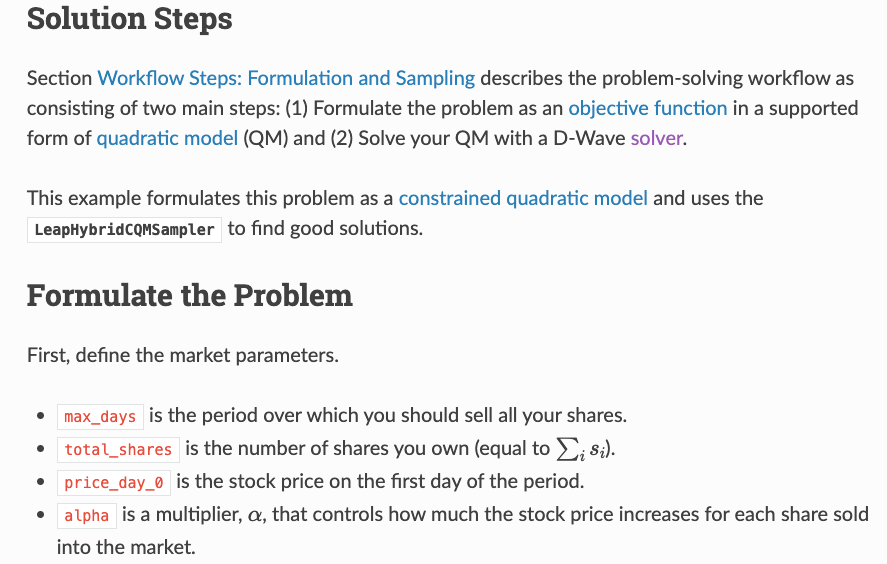



In [2]:
max_days = 10
total_shares = 100
price_day_0 = 50
alpha = 1

In [3]:
from dimod import ConstrainedQuadraticModel
cqm = ConstrainedQuadraticModel()

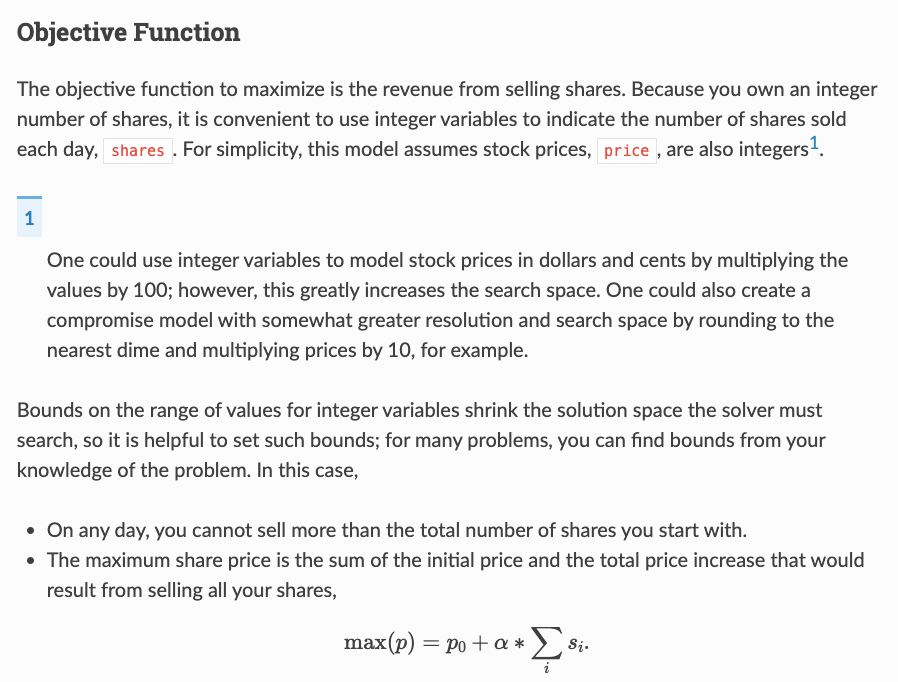

https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/quadratic.html#dimod.binary.BinaryQuadraticModel

In [5]:
from dimod import Integer

max_p = price_day_0 + alpha*total_shares

# define an array of shares, with an element for each day in [0...max_days-1]
# elements are objects of dimod.QuadraticModel class
# https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/quadratic.html#dimod.binary.BinaryQuadraticModel
shares = [Integer(f's_{i}', upper_bound=total_shares) for i in range(max_days)]


price = [Integer(f'p_{i}', upper_bound=max_p) for i in range(max_days)]

revenue = [s*p for s, p in zip(shares, price)]

cqm.set_objective(-sum(revenue))

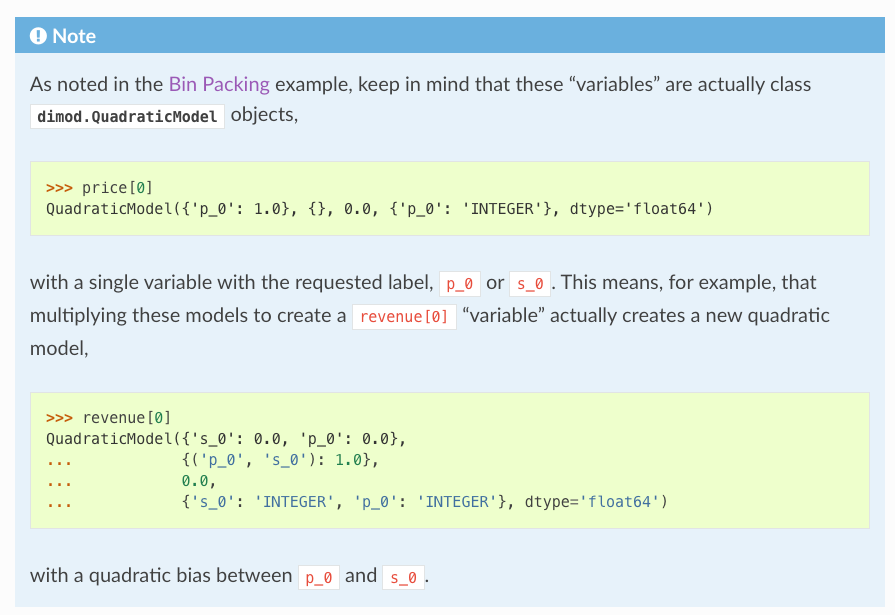

In [6]:
revenue[1]

QuadraticModel({'s_1': 0.0, 'p_1': 0.0}, {('p_1', 's_1'): 1.0}, 0.0, {'s_1': 'INTEGER', 'p_1': 'INTEGER'}, dtype='float64')

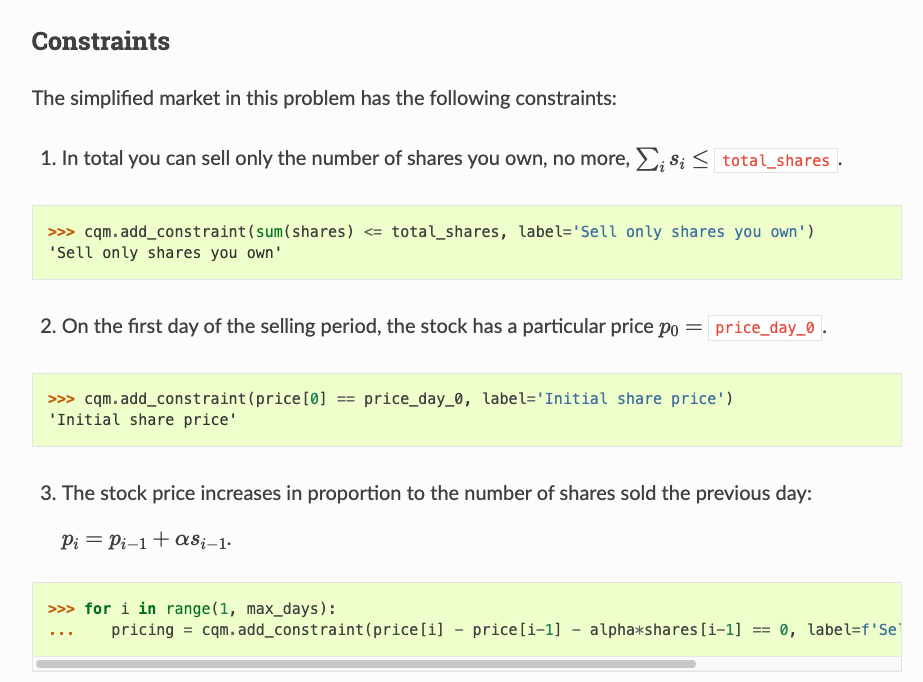

In [7]:
cqm.add_constraint(sum(shares) <= total_shares, label='Sell only shares you own')
cqm.add_constraint(price[0] == price_day_0, label='Initial share price')

for i in range(1, max_days):
    pricing = cqm.add_constraint(price[i] - price[i-1] - alpha*shares[i-1] == 0, label=f'Sell at the price on day {i}')
    
len(cqm.constraints)


'Sell only shares you own'

'Initial share price'

11

In [11]:
cqm

In [12]:
cqm.constraints

{'Sell only shares you own': QuadraticModel({'s_0': 1.0, 's_1': 1.0, 's_2': 1.0, 's_3': 1.0, 's_4': 1.0, 's_5': 1.0, 's_6': 1.0, 's_7': 1.0, 's_8': 1.0, 's_9': 1.0}, {}, 0.0, {'s_0': 'INTEGER', 's_1': 'INTEGER', 's_2': 'INTEGER', 's_3': 'INTEGER', 's_4': 'INTEGER', 's_5': 'INTEGER', 's_6': 'INTEGER', 's_7': 'INTEGER', 's_8': 'INTEGER', 's_9': 'INTEGER'}, dtype='float64') <= 100,
 'Initial share price': QuadraticModel({'p_0': 1.0}, {}, 0.0, {'p_0': 'INTEGER'}, dtype='float64') == 50,
 'Sell at the price on day 1': QuadraticModel({'p_1': 1.0, 'p_0': -1.0, 's_0': -1.0}, {}, -0.0, {'p_1': 'INTEGER', 'p_0': 'INTEGER', 's_0': 'INTEGER'}, dtype='float64') == 0,
 'Sell at the price on day 2': QuadraticModel({'p_2': 1.0, 'p_1': -1.0, 's_1': -1.0}, {}, -0.0, {'p_2': 'INTEGER', 'p_1': 'INTEGER', 's_1': 'INTEGER'}, dtype='float64') == 0,
 'Sell at the price on day 3': QuadraticModel({'p_3': 1.0, 'p_2': -1.0, 's_2': -1.0}, {}, -0.0, {'p_3': 'INTEGER', 'p_2': 'INTEGER', 's_2': 'INTEGER'}, dtype='flo

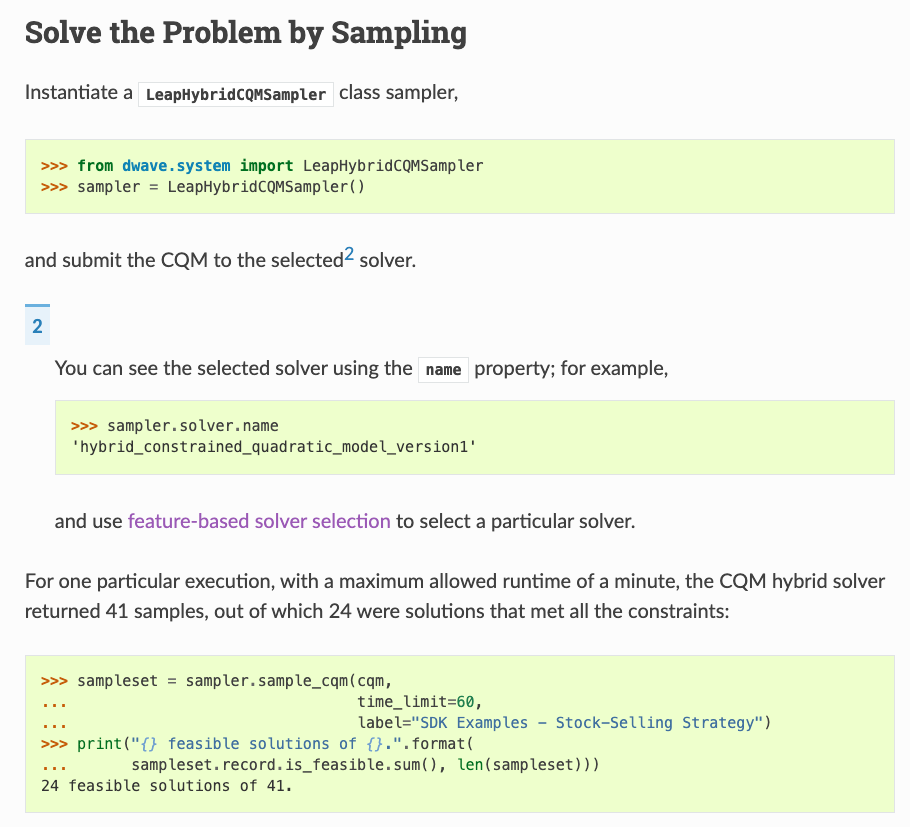

In [8]:
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler()     

In [9]:
sampler.solver.name

'hybrid_constrained_quadratic_model_version1'

In [10]:
sampler.solver

CQMSolver(id='hybrid_constrained_quadratic_model_version1')

In [13]:
# set time limit to 5 sec to conserve credits
sampleset = sampler.sample_cqm(cqm,
    time_limit=5,
    label="MD learning: Stock-Selling Strategy")

print("{} feasible solutions of {}.".format(
    sampleset.record.is_feasible.sum(), 
    len(sampleset)))   

34 feasible solutions of 51.


In [14]:
sampleset

SampleSet(rec.array([([ 50., 150., 150., 150., 150., 150., 150., 150., 150., 150., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.], -140000., 1, False, [False, False, False, False, False,  True, False, False, False, False,  True]),
           ([ 50., 150., 150., 150., 150., 150., 150., 150., 150., 150., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.], -140000., 1, False, [False, False, False, False, False,  True, False, False, False, False,  True]),
           ([ 50., 150., 150., 150., 150., 150., 150., 150., 150., 150., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.], -140000., 1, False, [False, False, False, False, False,  True, False, False, False, False,  True]),
           ([ 50., 150., 150., 150., 150., 150., 150., 150., 150., 150., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.], -140000., 1, False, [False, False, False, False, False,  True, False, False, False, False,  True]),
           ([ 50., 150., 150., 150., 150., 150., 150.,

In [15]:

# extract the best solution - w max revenue - and show details
def parse_best(sampleset):
   best = sampleset.filter(lambda row: row.is_feasible).first

   s = [val for key, val in best.sample.items() if "s_" in key]
    
   p = [val for key, val in best.sample.items() if "p_" in key]

   r = [p*s for p, s in zip(p, s)]
    
   return r, s, best

In [16]:
r, s, _ = parse_best(sampleset)
print("Revenue of {} found for daily sales of: \n{}".format(sum(r), s))  

Revenue of 9496.0 found for daily sales of: 
[10.0, 10.0, 10.0, 10.0, 9.0, 10.0, 9.0, 12.0, 11.0, 9.0]


In [18]:
best = sampleset.filter(lambda row: row.is_feasible).first
best

Sample(sample={'p_0': 50.0, 'p_1': 60.0, 'p_2': 70.0, 'p_3': 80.0, 'p_4': 90.0, 'p_5': 99.0, 'p_6': 109.0, 'p_7': 118.0, 'p_8': 130.0, 'p_9': 141.0, 's_0': 10.0, 's_1': 10.0, 's_2': 10.0, 's_3': 10.0, 's_4': 9.0, 's_5': 10.0, 's_6': 9.0, 's_7': 12.0, 's_8': 11.0, 's_9': 9.0}, energy=-9496.0, num_occurrences=1, is_feasible=True, is_satisfied=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]))